# Mobile price classification with multilayer perceptron
## PyTorch
Erik Matovič and Jakub Horvat

[Dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv)

### 0. Imports

In [100]:
import wandb
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from utils import split_train_val
from typing import Tuple, List

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda, device)

True cuda:0


### 2. Data transformation
 - no null values
 - load train and test datasets & from test dataset make validation and test dataset

In [101]:
# read datasets
df_train = pd.read_csv('../data/train.csv', sep=',')
df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [102]:
df_test = pd.read_csv('../data/test.csv', sep=',', index_col=0)
df_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
id,,,,,,,,,,,,,,,,,,,,
1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0
997,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1
998,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0


In [103]:
X_train = df_train.values[:, :-1]       # store the inputs
X_train = X_train.astype('float32')     # input data as floats
X_train

array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], dtype=float32)

In [104]:
y_train = df_train.values[:, -1]  # store the outputs
y_train = y_train.astype('int')     # input data as floats
y_train

array([1, 2, 2, ..., 3, 0, 3])

In [105]:
# make dataset from X and y
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_ds

In [106]:
batch_size = 32
tf_train, tf_val = split_train_val(train_ds)

print(tf_train.dataset)
print(tf_val.dataset)

In [107]:
train_dl = DataLoader(tf_train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(tf_val, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(torch.tensor(df_test.values.astype('float32')), batch_size=batch_size, shuffle=False)

print(len(train_dl.dataset))
print(len(val_dl.dataset))
print(len(test_dl.dataset))

print(train_dl.dataset)
print(val_dl.dataset)
print(test_dl.dataset)

1800
200
1000
tensor([[1.0430e+03, 1.0000e+00, 1.8000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [8.4100e+02, 1.0000e+00, 5.0000e-01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.8070e+03, 1.0000e+00, 2.8000e+00,  ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        ...,
        [1.1850e+03, 0.0000e+00, 1.4000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5330e+03, 1.0000e+00, 5.0000e-01,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [1.2700e+03, 1.0000e+00, 5.0000e-01,  ..., 1.0000e+00, 0.0000e+00,
         1.0000e+00]])


In [108]:
train_dl.dataset

## Model

In [109]:
class MLP(nn.Module):
    """ 
    Model class.
    :param Module from torch.nn
    """
    def __init__(self, n_inputs: int, n_classes: int, lr: float, momentum: float) -> None:
        """
        Model elements init.
        """
        super(MLP, self).__init__()
        self.n_inputs = n_inputs
        self.n_classes = n_classes
        self.lr = lr
        self.momentum = momentum
    
        # input to first hidden layer
        # pridať hlbku aj šírku siete
        # skúsiť normalizovať dáta
        self.dense1 = nn.Linear(n_inputs, 32)
        # second hidden layer
        self.dense2 = nn.Linear(32, 32)
        # third hidden layer and output
        self.dense3 = nn.Linear(32, n_classes)
        # activation f
        self.relu = nn.ReLU()
        #self.softmax = nn.Softmax()
        # prv začat bez dropout, ptm pridat, pozrieť sa na parametre 
        # dropout pomaha proti preuceniu
        self.droput = nn.Dropout(0.2)
 
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        """
        Feed forward
        """
        # print(type(X))
        #print(self.n_inputs)
        # input to first hidden layer
        output = self.dense1(X)
        output = self.relu(output)
        # output = self.droput(output)
        
        # second hidden layer
        output = self.dense2(output)
        output = self.relu(output)
        # output = self.droput(output)
        
        # third hidden layer and output
        output = self.dense3(output)
        # output = self.softmax(output)
        # print(type(output))

        # print(type(output))
        return output

In [110]:
def train_mlp(n_epochs, mlp, optimizer, loss_fn, train_loader, 
              val_loader, device=device) -> Tuple[List, List, List, List]:
    """ 
    Train the model
    """
    # init train lists for statistics
    loss_train, accuracy_train = list(), list()

    # init validation lists for statistics
    loss_validation, accuracy_validation = list(), list()

    # enumerate epochs
    for epoch in range(n_epochs):
        # init epoch train counters
        epoch_train_accuracy, epoch_train_total, epoch_train_true, epoch_train_loss = 0, 0, 0, 0

        # init epoch validation counters
        epoch_validation_accuracy, epoch_validation_total, \
            epoch_validation_true, epoch_validation_loss = 0, 0, 0, 0

        # enumerate mini batches
        for idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            y_hat = mlp(X_batch)
            # calculate loss
            # y_hat2 = torch.flatten(y_hat)
            # print(y_hat.dtype, '\flat:\n', y_hat2, 'batch:', y_batch.shape)
            
            # print(y_hat[0])
            # print(y_hat[1])
            # print(y_hat[2])
            # print(y_hat[3])

            # print(y_batch)
            
            loss = loss_fn(y_hat, y_batch)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            # update train counters
            epoch_train_loss += loss.item()
            #print(y_batch.shape, y_hat.shape)
            #print(y_hat)
            #epoch_train_true += (y_batch == y_hat).sum().item()
            epoch_train_total += len(y_batch)
        
        # update train accuracy & loss statistics
        epoch_train_accuracy = epoch_train_true/epoch_train_total
        epoch_train_loss /= (len(train_loader.dataset)/batch_size)

        # disable gradient calculation
        with torch.no_grad():
            # enumerate mini batches
            for idx, (X_batch, y_batch) in enumerate(val_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute the models output
                y_hat = mlp(X_batch)
                # calculate loss
                loss = loss_fn(y_hat, y_batch)

                # update validation counters
                epoch_validation_loss += loss.item()
                #epoch_validation_true += (y_batch == y_hat).sum().item()
                epoch_validation_total += len(y_batch)
        
        # update validation accuracy & loss statistics
        epoch_validation_accuracy = epoch_validation_true/epoch_validation_total
        epoch_validation_loss /= (len(val_loader.dataset)/batch_size)

        # update global epochs statistics
        loss_train.append(epoch_train_loss)
        accuracy_train.append(epoch_train_accuracy)
        loss_validation.append(epoch_validation_loss)
        accuracy_validation.append(epoch_validation_accuracy)

        # WandB log
        # TO DO

        # print
        print(
            f'Epoch {epoch}/{n_epochs}: \
            \t train loss {loss_train[-1]}, \
            \t validation loss {loss_validation[-1]}, \
            \t train accuracy {accuracy_train[-1]}, \
            \t validation accuracy {accuracy_validation[-1]}'
        )

    return loss_train, accuracy_train, loss_validation, accuracy_validation

In [111]:
import warnings
warnings.filterwarnings('ignore')

learning_rate = 0.001 
momentum = 0.9

input_size = 20          # number of features
hidden_size = 32         # number of features in hidden state
num_classes = 4          # number of output classes 

mlp = MLP( 
    n_inputs=input_size, 
    n_classes=num_classes,
    lr=learning_rate,
    momentum=momentum)
mlp.to(device)

MLP(
  (dense1): Linear(in_features=20, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
  (droput): Dropout(p=0.2, inplace=False)
)

define the optimization and loss function

In [113]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate) # SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)

In [115]:
n_epochs = 50 

loss_train, accuracy_train, loss_validation, accuracy_validation = train_mlp(
    n_epochs=n_epochs,
    mlp=mlp,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_dl,
    val_loader=val_dl,
    device=device
)

Epoch 0/50:             	 train loss 29.071892717149524,             	 validation loss 15.279255981445312,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 1/50:             	 train loss 8.471942893134223,             	 validation loss 5.5169462394714355,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 2/50:             	 train loss 3.6216477860344782,             	 validation loss 4.228103866577149,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 3/50:             	 train loss 3.1161377228630913,             	 validation loss 2.483948440551758,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 4/50:             	 train loss 1.9248540751139323,             	 validation loss 2.295599689483643,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 5/50:             	 train loss 1.6808526261647543,             	 validation loss 1.4498973274230957,   

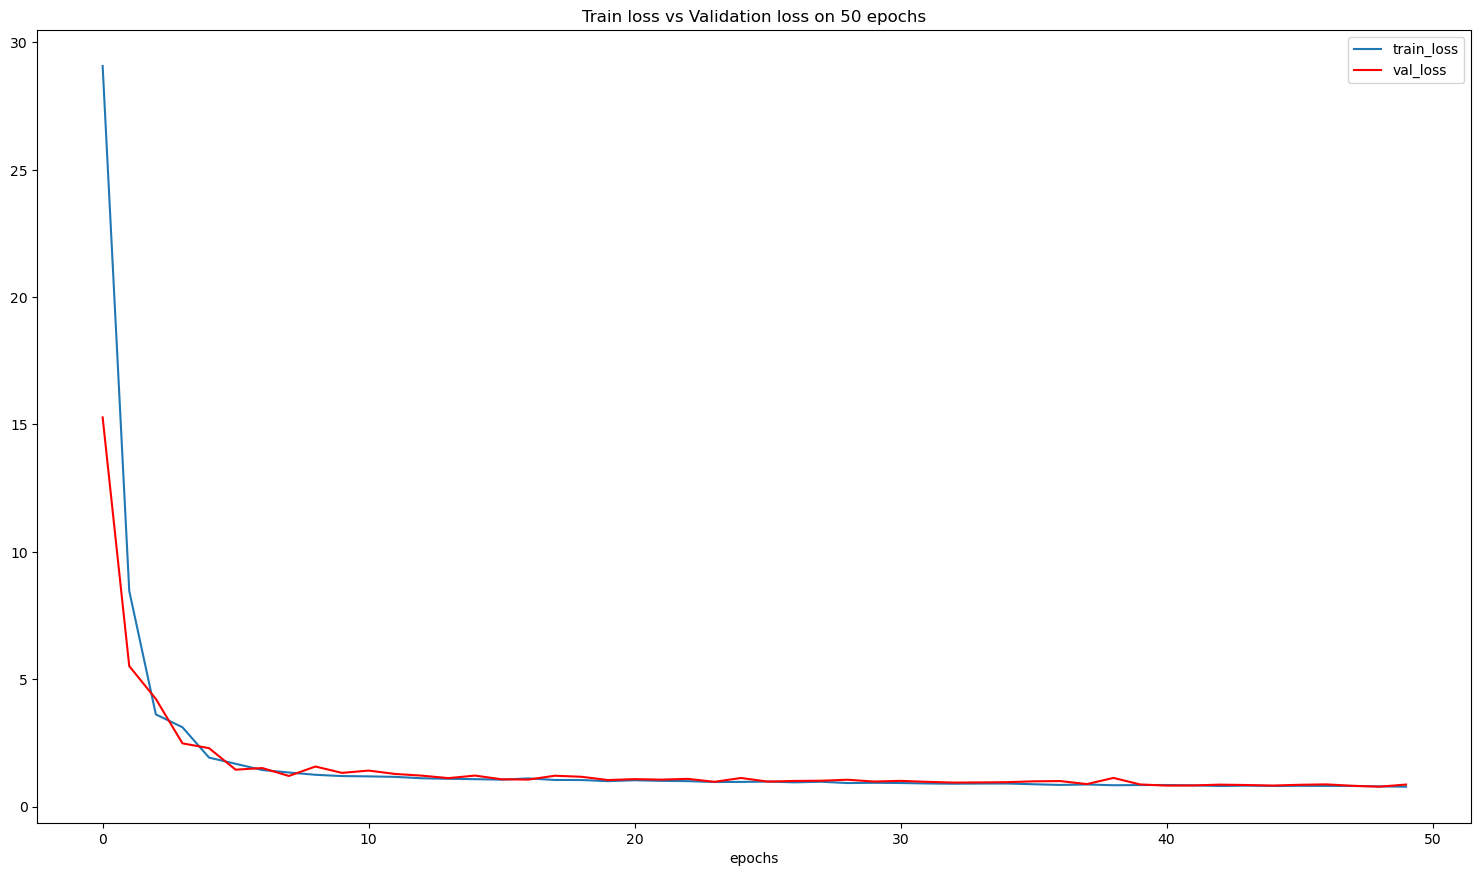

In [116]:
from matplotlib import pyplot as plt
 
def plot_loss(train_loss, val_loss):
    '''
    Visualize training loss vs. validation loss.
    Parameters
    ----------
    train_loss: training loss
    val_loss: validation loss
    Returns: None
    -------
    '''
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    loss_csv = pd.DataFrame({"epochs": range(len(train_loss)), "train_loss": train_loss,
                             "val_loss": val_loss})
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    loss_csv.plot(kind='line',x='epochs',y='train_loss',ax=ax )
    loss_csv.plot(kind='line',x='epochs',y='val_loss', color='red', ax=ax)
    plt.title(f'Train loss vs Validation loss on {len(train_loss)} epochs')
    plt.show()
    # plt.savefig("../outputs/train_vs_val_loss.png")

# Examine results
plot_loss(loss_train, loss_validation)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


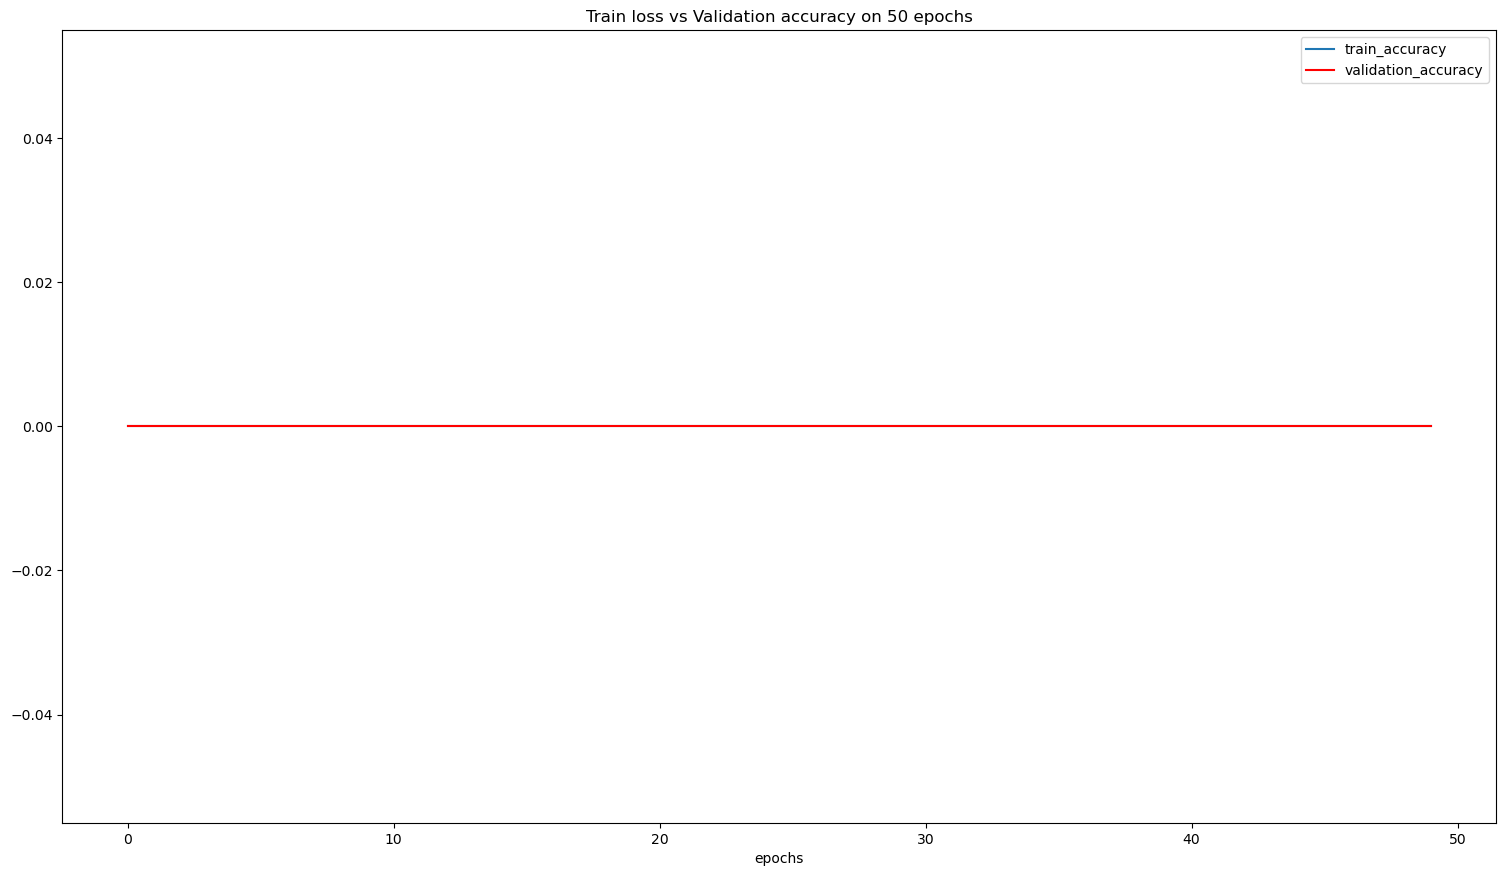

In [117]:
def plot_accuracy(train_accuracy, validation_accuracy):
    """
    TODO: refactor
    """
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    accuracy_csv = pd.DataFrame({
        "epochs": range(len(train_accuracy)), 
        "train_accuracy": train_accuracy,
        "validation_accuracy": validation_accuracy
    })
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    accuracy_csv.plot(kind='line',x='epochs',y='train_accuracy', ax=ax)
    accuracy_csv.plot(kind='line',x='epochs',y='validation_accuracy', color='red', ax=ax)
    plt.title(f'Train loss vs Validation accuracy on {len(train_accuracy)} epochs')
    plt.show()

print(accuracy_train, accuracy_validation)
plot_accuracy(accuracy_train, accuracy_validation)

In [118]:
#df_X_ss = high_scaler.inverse_transform(X_test) # old transformers
#df_y_mm = high_scaler.inverse_transform(y_test) # old transformers

# split the sequence

# converting to tensors
#df_X_ss = Variable(torch.Tensor(df_X_ss))
#df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
#df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))
true, preds = [], []
# test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors), shuffle=False, batch_size=32)
for idx, X_batch in enumerate(test_dl):
    #print(y_batch)
    #break
    X_batch = X_batch.to(device)
    train_predict = mlp(X_batch) #X_test_tensors) # forward pass
    # torch.reshape(train_predict, (32, 1))
    data_predict = train_predict.cpu().data.numpy() # numpy conversion
    # dataY_plot = y_batch.data.numpy() # y_test_tensors.data.numpy()
    # print(data_predict[0].shape)
    # reverse transformation
    # data_predict = event_scaler.inverse_transform(data_predict[0]) 
    # dataY_plot = event_scaler.inverse_transform(dataY_plot)
    # true, preds = [], []
    #for i in range(len(dataY_plot)):
    #    true.append(dataY_plot[i][0])
    for i in range(len(data_predict)):
        # print(data_predict)
        preds.append(data_predict[i][0])

preds

[-25.18835,
 -34.959557,
 -3.4996955,
 -20.803446,
 -2.8113327,
 -19.01442,
 -22.290127,
 8.772235,
 -23.84472,
 11.533969,
 -16.205988,
 -29.305408,
 17.553339,
 38.109413,
 0.27140847,
 46.033142,
 -2.4158516,
 -0.5566572,
 -21.554802,
 -21.468914,
 31.330336,
 -20.321594,
 -1.9769732,
 0.27140847,
 -39.984436,
 30.120012,
 -16.525478,
 11.019178,
 -14.454321,
 4.938255,
 -10.202614,
 24.713001,
 -20.205585,
 22.074799,
 6.8733854,
 10.306226,
 -18.288311,
 -5.577177,
 -18.819494,
 -20.308739,
 13.561508,
 -4.542787,
 11.962477,
 49.74182,
 38.700043,
 -3.6929278,
 2.024644,
 -8.309422,
 17.424995,
 -9.788513,
 -0.023500353,
 6.5545225,
 -7.6261244,
 -3.1219594,
 -20.381927,
 11.8115225,
 -26.057304,
 1.6435716,
 0.06735486,
 -43.58432,
 -28.230303,
 -8.949297,
 0.27140847,
 -1.8809925,
 9.85161,
 -5.111064,
 -2.9560678,
 -10.734477,
 -3.4850068,
 -6.4516835,
 6.5196548,
 -8.763587,
 -7.8113112,
 -14.806311,
 -19.036217,
 12.025929,
 -8.835584,
 36.266922,
 -7.2433825,
 -20.7431,
 10

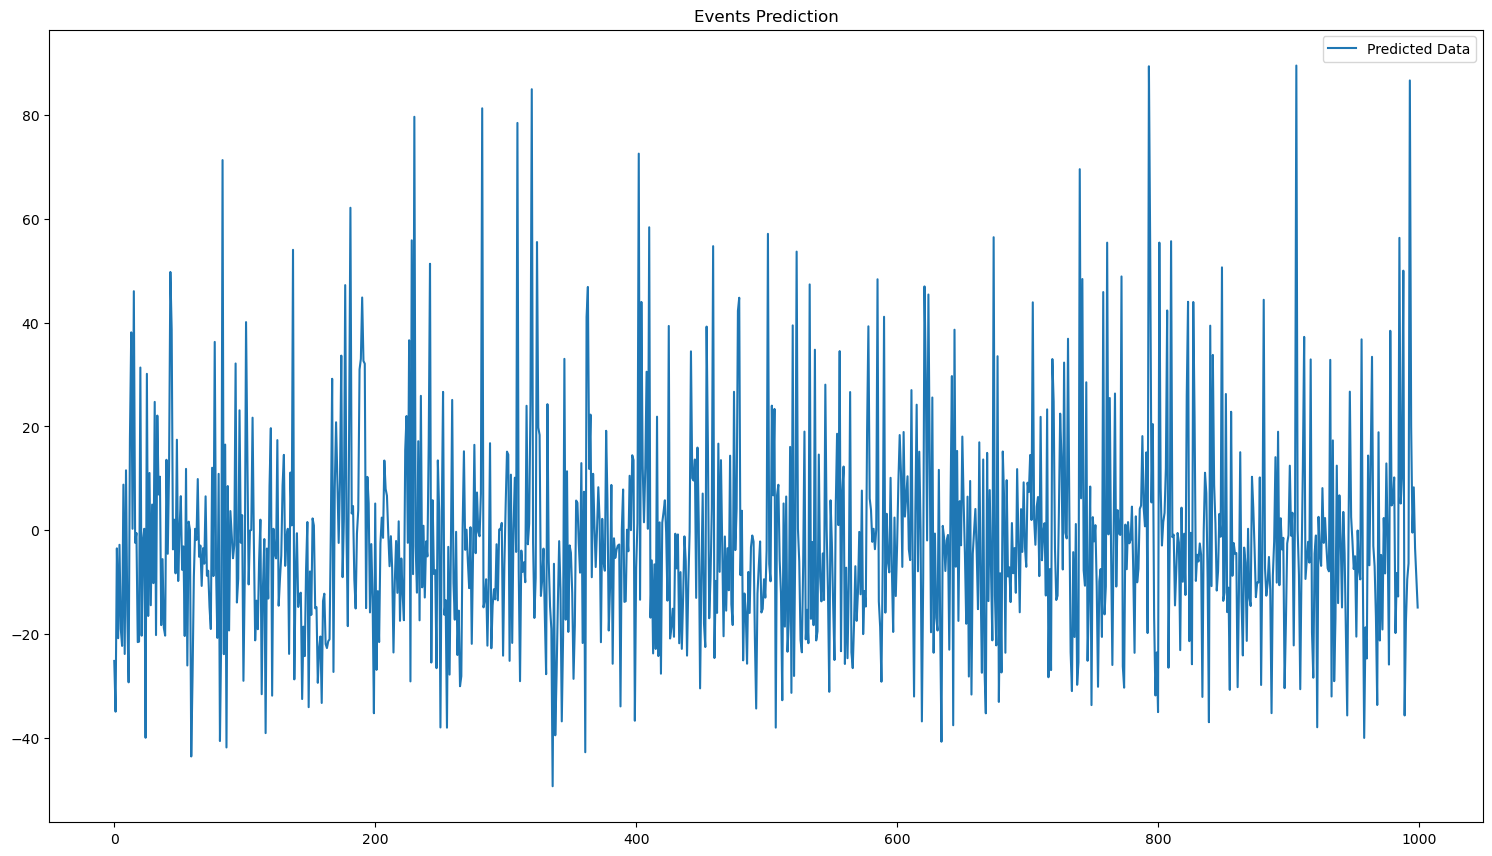

In [119]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)
#plt.axvline(x=0.95, c='r', linestyle='--') # size of the training set

#plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Events Prediction')
#plt.xlim([500, 1000])
#plt.ylim([0, 7])
# my_yticks = ['', ]
#plt.yticks(true, true_new)
#plt.yticks(preds_round, preds_new)
plt.legend()
#plt.savefig("../outputs/1_bitcoin_high_prediction_pytorch.png", transparent=False, dpi=300)
plt.show() 

In [120]:
#df_X_ss = high_scaler.inverse_transform(X_test) # old transformers
#df_y_mm = high_scaler.inverse_transform(y_test) # old transformers

# split the sequence

# converting to tensors
#df_X_ss = Variable(torch.Tensor(df_X_ss))
#df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
#df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))
true_val, preds_val = [], []
# test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors), shuffle=False, batch_size=32)
for idx, (X_batch, y_batch) in enumerate(val_dl):
    #print(y_batch)
    #break
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    train_predict = mlp(X_batch) #X_test_tensors) # forward pass
    # torch.reshape(train_predict, (32, 1))
    data_predict = train_predict.cpu().data.numpy() # numpy conversion
    dataY_plot = y_batch.cpu().data.numpy() # y_test_tensors.data.numpy()
    # print(data_predict[0].shape)
    # reverse transformation
    # data_predict = event_scaler.inverse_transform(data_predict[0]) 
    # dataY_plot = event_scaler.inverse_transform(dataY_plot)
    # true, preds = [], []
    for i in range(len(dataY_plot)):
        #print(dataY_plot[i])
        true_val.append(dataY_plot[i])
    for i in range(len(data_predict)):
        # print(data_predict)
        preds_val.append(data_predict[i][0])

preds

[-25.18835,
 -34.959557,
 -3.4996955,
 -20.803446,
 -2.8113327,
 -19.01442,
 -22.290127,
 8.772235,
 -23.84472,
 11.533969,
 -16.205988,
 -29.305408,
 17.553339,
 38.109413,
 0.27140847,
 46.033142,
 -2.4158516,
 -0.5566572,
 -21.554802,
 -21.468914,
 31.330336,
 -20.321594,
 -1.9769732,
 0.27140847,
 -39.984436,
 30.120012,
 -16.525478,
 11.019178,
 -14.454321,
 4.938255,
 -10.202614,
 24.713001,
 -20.205585,
 22.074799,
 6.8733854,
 10.306226,
 -18.288311,
 -5.577177,
 -18.819494,
 -20.308739,
 13.561508,
 -4.542787,
 11.962477,
 49.74182,
 38.700043,
 -3.6929278,
 2.024644,
 -8.309422,
 17.424995,
 -9.788513,
 -0.023500353,
 6.5545225,
 -7.6261244,
 -3.1219594,
 -20.381927,
 11.8115225,
 -26.057304,
 1.6435716,
 0.06735486,
 -43.58432,
 -28.230303,
 -8.949297,
 0.27140847,
 -1.8809925,
 9.85161,
 -5.111064,
 -2.9560678,
 -10.734477,
 -3.4850068,
 -6.4516835,
 6.5196548,
 -8.763587,
 -7.8113112,
 -14.806311,
 -19.036217,
 12.025929,
 -8.835584,
 36.266922,
 -7.2433825,
 -20.7431,
 10

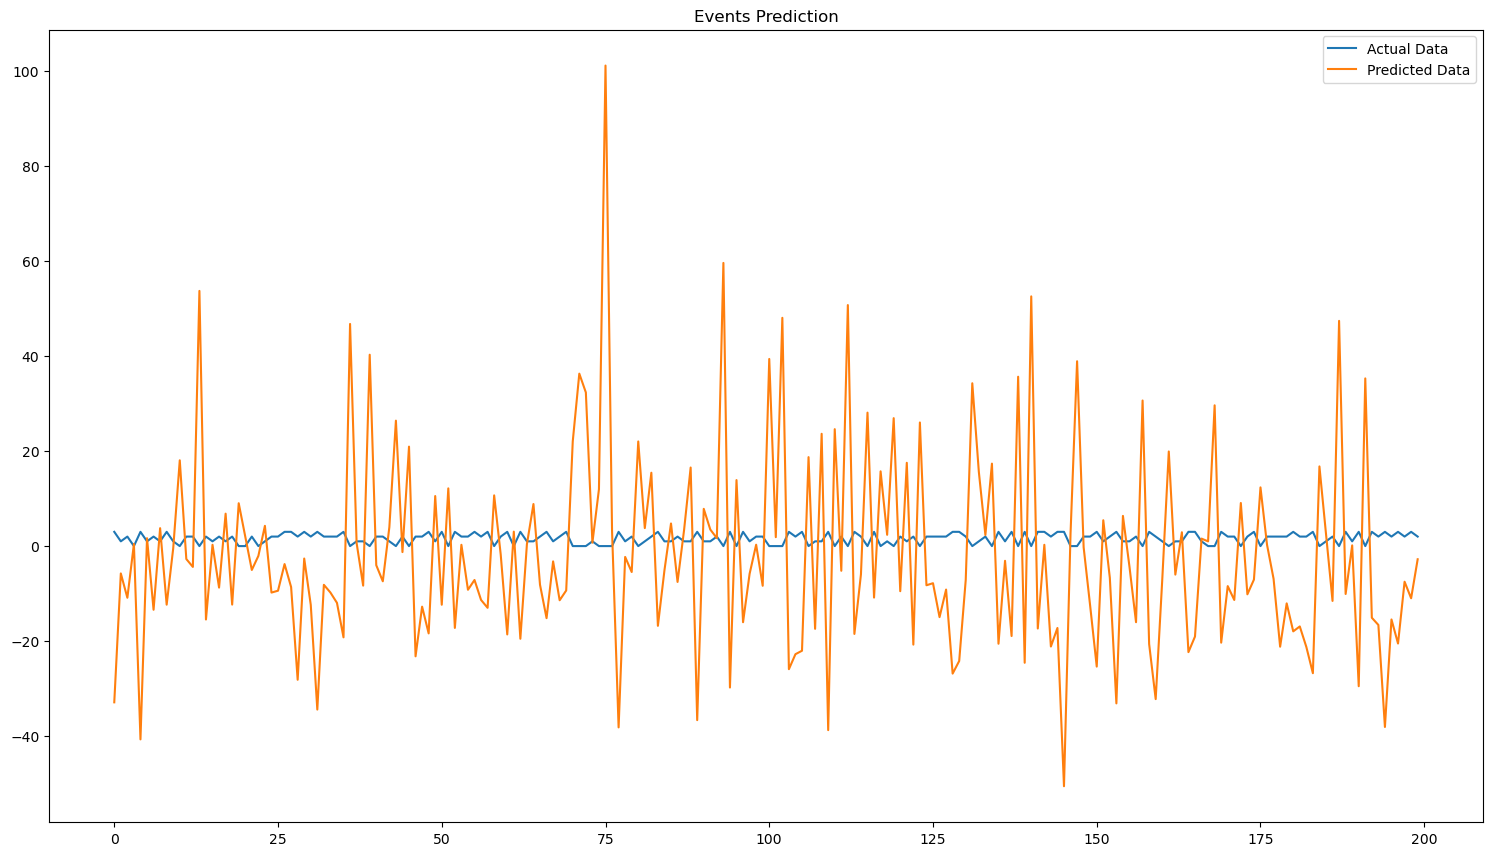

In [121]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)
#plt.axvline(x=0.95, c='r', linestyle='--') # size of the training set

plt.plot(true_val, label='Actual Data') # actual plot
plt.plot(preds_val, label='Predicted Data') # predicted plot
plt.title('Events Prediction')
#plt.xlim([500, 1000])
#plt.ylim([0, 7])
# my_yticks = ['', ]
#plt.yticks(true, true_new)
#plt.yticks(preds_round, preds_new)
plt.legend()
#plt.savefig("../outputs/1_bitcoin_high_prediction_pytorch.png", transparent=False, dpi=300)
plt.show() 